In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import copy

# from IPython.display import HTML
# from IPython import display
# from IPython.display import clear_output

# from gym.wrappers.record_video import RecordVideo
from gym_minigrid.wrappers import *

from minigrid.wrappers import FullyObsWrapper, ImgObsWrapper, NoDeath
from minigrid.core.actions import Actions



# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Flatten
# from tensorflow.keras.optimizers import Adam

from minigrid_custom_env import *
from minigrid_custom_train import *


plt.rcParams['figure.figsize'] = (6.0, 6.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%matplotlib inline
%reload_ext autoreload

%load_ext autoreload
%autoreload 2

c:\Users\matan\miniconda3\envs\my_project\lib\site-packages\gym\envs\registration.py:307: DeprecationWarning: The package name gym_minigrid has been deprecated in favor of minigrid. Please uninstall gym_minigrid and install minigrid with `pip install minigrid`. Future releases will be maintained under the new package name minigrid.
  fn()
<frozen importlib._bootstrap>:241: RuntimeWarning: Your system is avx2 capable but pygame was not built with support for it. The performance of some of your blits could be adversely affected. Consider enabling compile time detection with environment variables like PYGAME_DETECT_AVX2=1 if you are compiling without cross compilation.



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:

import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import time
import copy

env = CustomEnv(size = 10, render_mode='rgb_array', difficult_grid=False, agent_pov=True)
env = ImgObsWrapper(ObjObsWrapper(env))


current_obs = env.reset()
current_obs = current_obs[0]
img = env.render()



7


In [ ]:
x = [1,2,3,4,5,6,7]
y = x[9:]

[7, 6, 5, 4, 3, 2, 1]

7
7


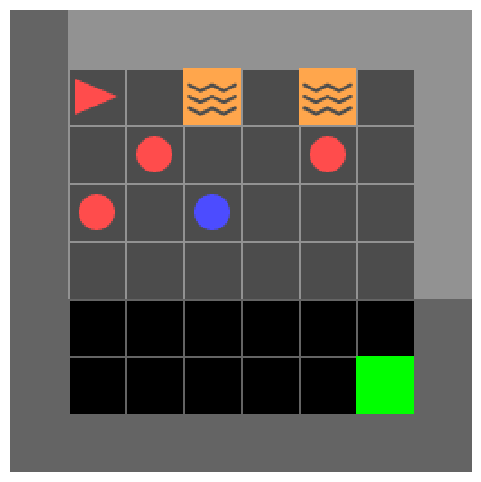

points {0: (1, 1, 0), 1: (2, 2, 2), 2: (1, 3, 2), 3: (2, 2, 2), 4: (5, 2, 2), 5: (3, 3, 2)}
Total reward: 7.4, Total steps: 14.0


c:\Users\matan\miniconda3\envs\my_project\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.find_optimal_path to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.find_optimal_path` for environment variables or `env.get_wrapper_attr('find_optimal_path')` that will search the reminding wrappers.
  logger.warn(


In [3]:
#test the environment

def plot_state(env):
    img = env.render()

    plt.imshow(img)
    plt.axis("off")
    plt.show()

env = CustomEnv(grid_size=8, render_mode='rgb_array', difficult_grid=False, max_steps=300, highlight=True, unique_env=0,
                        num_objects=5, lava_cells=2, train_env=True, image_full_view=False, agent_view_size=7, partial_obs=False)
env = NoDeath(ObjObsWrapper(env), no_death_types=('lava',), death_cost=-1.0)
env = ImgObsWrapper(ObjObsWrapper(env))

state, _ = env.reset()
plot_state(env)


#test the environment
total_reward, total_steps = env.find_optimal_path()
print(f"Total reward: {total_reward}, Total steps: {total_steps}")
env.close()

In [30]:
def load_agent(env, model_path):
    # policy_kwargs = dict(features_extractor_class=ObjEnvExtractor)
    custom_objects = {
        "policy_kwargs": {"features_extractor_class": ObjEnvExtractor},  # Example kernel size
        "clip_range": 0.2,  # Example custom parameters
        "lr_schedule": 0.001  # Example learning rate schedule
    }
    # Load the model
    ppo = PPO.load(f"models/{model_path}", custom_objects=custom_objects, env=env)
    return ppo

def is_illegal_move(action, last_obs, obs, agent_pos_befor, agent_pos):
    if action <= 1: # turn is always legal
        return False
    if action == 2 and agent_pos_befor == agent_pos:
        return True
    if action > 2 and np.array_equal(obs['image'], last_obs['image']):
        return True
    return False

# resert the environment and run the agent on that environment to find his path
def capture_agent_path(copy_env, agent):
    illigal_moves = 0
    last_obs = copy_env.unwrapped.current_state
    
    # last_obs = env.reset()
    # last_obs = last_obs[0]
    ligal_actions = []
    agent_actions = []
    state_record = [last_obs]
    total_reward = 0    
    done = False
    # copy_env = copy.deepcopy(env)
    # plt.imshow(copy_env.render())
    while not done:
        agent_pos_before = copy_env.unwrapped.agent_pos
        action, _states = agent.predict(last_obs)
        agent_actions.append(action)
        obs, reward, done, _, info = copy_env.step(action)
        total_reward += reward
        
        if is_illegal_move(action, last_obs, obs, agent_pos_before, copy_env.agent_pos):
            illigal_moves += 1
            continue

        ligal_actions.append(action)
        last_obs = obs
        state_record.append(obs)
        # plt.imshow(copy_env.render())
        # plt.show()
        
        
    number_to_action = {0: 'turn right', 1: 'turn left', 3: 'pickup'}
    small_arrow = 'turn ' # small arrow is used to indicate the agent turning left or right
    agent_dir = "right"
    move_sequence = []
    for action in ligal_actions:
        if action == 0: # turn left
            agent_dir = turn_agent(agent_dir, "left")
            move_sequence.append(small_arrow + agent_dir)
        elif action == 1: # turn right
            agent_dir = turn_agent(agent_dir, "right")
            move_sequence.append(small_arrow + agent_dir)
        elif action == 2: # move forward
            move_sequence.append(agent_dir)
        elif action == 3: # pickup
            move_sequence.append('pickup ' +  agent_dir)
    return move_sequence, illigal_moves, total_reward, agent_actions


def turn_agent(agent_dir, turn_dir):
    turnning_dict = {("up", "left"): "left", ("up", "right"): "right", 
                     ("down", "left"): "right", ("down", "right"): "left",
                     ("left", "left"): "down", ("left", "right"): "up",
                     ("right", "left"): "up", ("right", "right"): "down"}
    return turnning_dict[(agent_dir, turn_dir)]

def plot_move_sequence(img, move_sequence, move_color='y', turn_color='orange', pickup_color='purple'):    
    start_point = (50, 50)
    arrow_size = 20
    arrow_head_size = 12
    small_shift = 9
    all_arrow_size = arrow_size + arrow_head_size
    move_arrow_sizes = {'up': (0, -20, 0, -all_arrow_size), 
                        'down': (0, 20, 0, all_arrow_size), 
                        'right': (20, 0, all_arrow_size, 0), 
                        'left': (-20, 0, -all_arrow_size, 0)}
    turn_arrow_sizes = {'turn up': (0, -5),
                        'turn down': (0, 5),
                        'turn right': (5, 0),
                        'turn left': (-5, 0)}
    pickup_direction = {'up': (0, -1),
                         'down': (0, 1),
                         'left': (-1, 0),
                         'right': (1, 0)}
    # arrows_list = ['right', 'right', 'down', 'down', 'down', 'down', 'down', 'right', 'right', 'up', 'right', 'down']

    fig, ax = plt.subplots()
    ax.imshow(img)
    current_point = start_point
    for action_name in move_sequence:
        if action_name in move_arrow_sizes.keys(): # a big arrow that represents a move
            ax.arrow(current_point[0], current_point[1], move_arrow_sizes[action_name][0], move_arrow_sizes[action_name][1], head_width=10, head_length=10, fc=move_color, ec=move_color)
            current_point = (current_point[0] + move_arrow_sizes[action_name][2], current_point[1] + move_arrow_sizes[action_name][3])
        else: # a small arrow that represents a turn or a pickup
            full_action = action_name.split(' ')
            action = full_action[0]
            pickup_position = pickup_direction[full_action[1]]
            
            if action == 'pickup':
                ax.plot(current_point[0] + small_shift * pickup_position[0], current_point[1] + small_shift*pickup_position[1], marker='*', markersize=10, color=pickup_color)
            else:
                ax.arrow(current_point[0], current_point[1], turn_arrow_sizes[action_name][0], turn_arrow_sizes[action_name][1], head_width=7, head_length=6, fc=turn_color, ec=turn_color)
            
            
    ax.axis('off')
    plt.show()

colors_reward = {'red': -2, 'green': 1, 'blue': 2}
env = CustomEnv(grid_size=8, render_mode='rgb_array', max_steps=2*10**2, agent_view_size=7, highlight=True, lava_cells=0, 
                partial_obs=False, colors_rewards=colors_reward)
env = NoDeath(ObjObsWrapper(env), no_death_types=('lava',), death_cost=-2.0)
model_path1 = "LavaHate8_20241112\iter_500000_steps"
model_path2 = "LavaLaver8_20241112\iter_500000_steps"

ppo1 = load_agent(env, "minigrid_custom_20240907/iter_90^5_steps")
ppo3 = load_agent(env, "orig_easy8_20241111\iter_1000000_steps")
ppo7 = load_agent(env, "LavaLaverRedN8_20241113\iter_500000_steps")
ppo5 = load_agent(env, model_path2)
ppo9 = load_agent(env, model_path1)
models = {"ppo1": ppo1, "ppo3": ppo3, "ppo5": ppo5,  "ppo7": ppo7,  "ppo9": ppo9}
colors_list = [
    "cyan", "magenta", "yellow", "white",
    "orange", "purple", "pink", "brown", "gray", "olive", "teal", "navy",
    "maroon", "lime", "indigo", "gold"]
colors_to_models = {"ppo1": "y", "ppo3": "w", "ppo5": "gold", "ppo7": "c", "ppo9": "gray"}


7
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


In [31]:
def evaluate_agent(env, agent, num_episodes=100):
    total_reward = 0
    total_illegal_moves = 0
    for i in range(num_episodes):
        env.reset()
        move_sequence, illigal_moves, reward, agent_actions = capture_agent_path(env, agent)
        total_reward += reward
        total_illegal_moves += illigal_moves
    return total_reward / num_episodes, total_illegal_moves / num_episodes

for model_name, model in models.items():
    avg_reward, avg_illegal_moves = evaluate_agent(env, model, num_episodes=100)
    print(f"Model: {model_name}, Average reward: {avg_reward}, Average illegal moves: {avg_illegal_moves}")

c:\Users\matan\anaconda3\envs\master_env\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.grid to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.grid` for environment variables or `env.get_wrapper_attr('grid')` that will search the reminding wrappers.
  logger.warn(
c:\Users\matan\anaconda3\envs\master_env\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.front_pos to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.front_pos` for environment variables or `env.get_wrapper_attr('front_pos')` that will search the reminding wrappers.
  logger.warn(
c:\Users\matan\anaconda3\envs\master_env\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.actions to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.actions` for environment va

Model: ppo1, Average reward: 4.0252, Average illegal moves: 4.75
Model: ppo3, Average reward: 6.048430000000001, Average illegal moves: 0.2
Model: ppo5, Average reward: 5.1891400000000045, Average illegal moves: 0.74
Model: ppo7, Average reward: 8.971045000000004, Average illegal moves: 0.18
Model: ppo9, Average reward: 4.6684149999999995, Average illegal moves: 0.05


reset state:


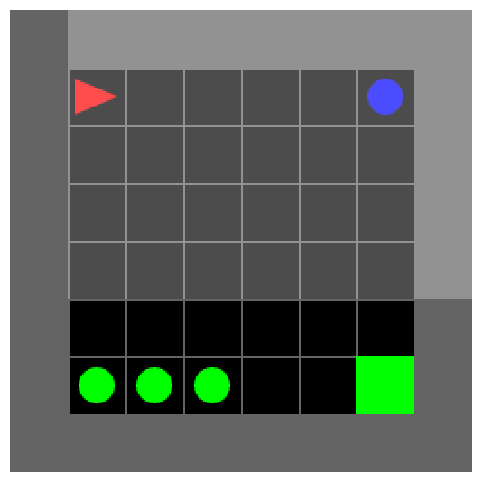

ligal actions:  ['right', 'turn down', 'down', 'down', 'down', 'down', 'pickup down', 'pickup down', 'down', 'turn right', 'pickup right', 'right', 'right', 'right', 'right']
model: ppo1, illigal moves: 3, total reward: 8.119


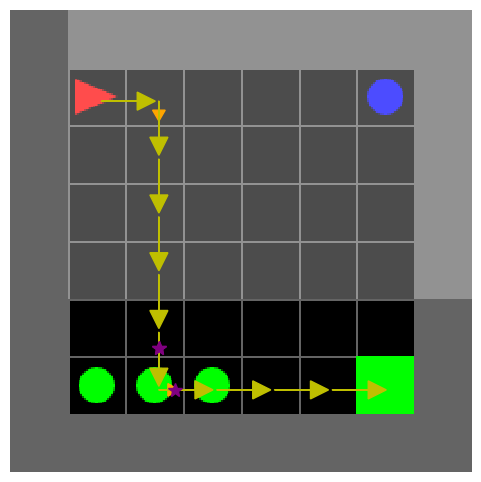

ligal actions:  ['turn down', 'down', 'down', 'down', 'down', 'pickup down', 'down', 'turn right', 'pickup right', 'right', 'pickup right', 'right', 'right', 'right', 'right']
model: ppo3, illigal moves: 0, total reward: 10.432500000000001


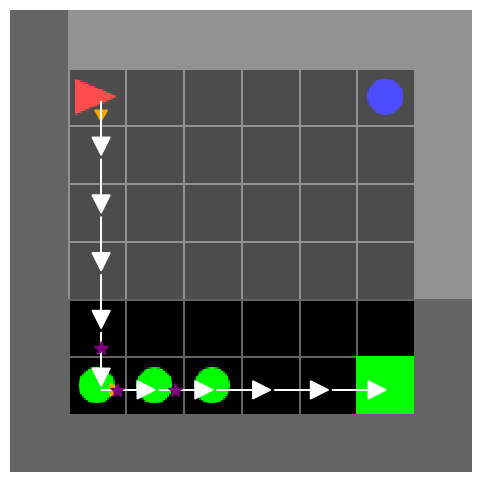

ligal actions:  ['right', 'right', 'right', 'right', 'pickup right', 'turn down', 'down', 'down', 'down', 'down', 'down', 'turn left', 'left', 'pickup left', 'left', 'pickup left', 'left', 'pickup left', 'turn up', 'turn right', 'right', 'right', 'right', 'right']
model: ppo5, illigal moves: 0, total reward: 11.492


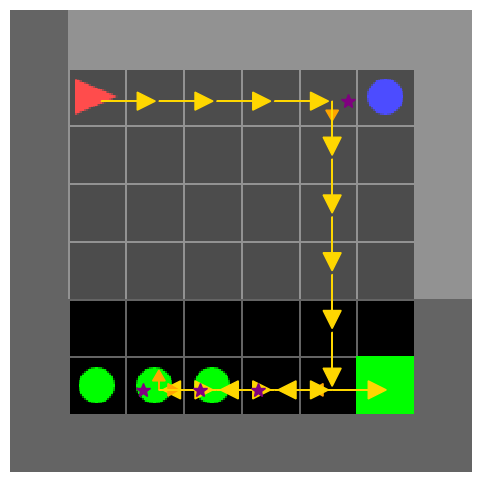

ligal actions:  ['right', 'right', 'right', 'right', 'pickup right', 'turn down', 'down', 'down', 'down', 'down', 'down', 'turn right', 'right']
model: ppo7, illigal moves: 0, total reward: 6.6415


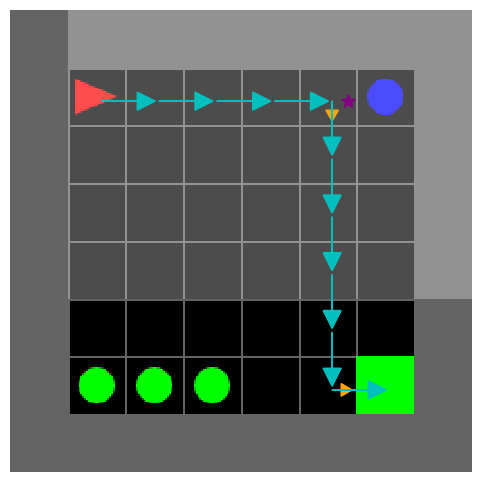

ligal actions:  ['turn down', 'down', 'down', 'down', 'down', 'pickup down', 'down', 'turn right', 'pickup right', 'right', 'pickup right', 'right', 'right', 'right', 'right']
model: ppo9, illigal moves: 1, total reward: 10.328


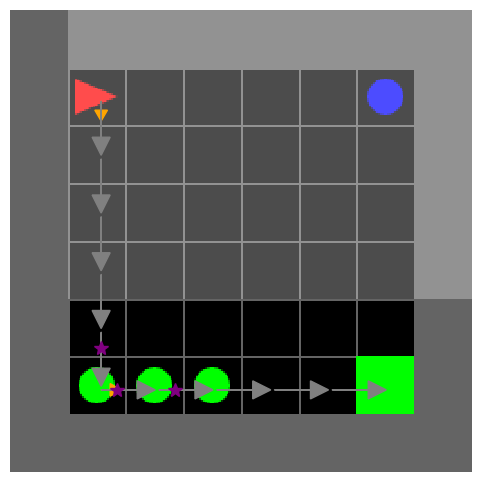

In [26]:
env.reset()
img = env.render()
print("reset state:")
plot_state(env)
model_name = 'ppo1'
model = models[model_name]
for model_name, model in models.items():
    copy_env = copy.deepcopy(env)
    # print("copy_env before:")
    # plot_state(copy_env)
    move_sequence, illigal_moves, total_reward, agent_action = capture_agent_path(copy_env, model)
    # print("all actions: ", agent_action)
    print("ligal actions: ", move_sequence)
    print(f"model: {model_name}, illigal moves: {illigal_moves}, total reward: {total_reward}")

    plot_move_sequence(img, move_sequence, move_color=colors_to_models[model_name])
    # print("orig env after:")
    # plot_state(env)
    


## Distance between 2 states

In [6]:
WALL_SHIFT_FACTOR = 1
WALL_FACTOR = 10
DOOR_FACTOR = 0.1
BALLS_FACTOR = 3
min_ball_distance = 3

def manhattan_distance(p1, p2):
    return np.abs(p1[0] - p2[0]) + np.abs(p1[1] - p2[1])
    
def balls_distance(balls):
    ball_dist = 0
    for i in range(len(balls)-1):
        for j in range(i+1, len(balls)):
            ball_dist += np.linalg.norm(np.array(balls[i][:-1]) - np.array(balls[j][:-1]))
    return ball_dist

def balls_groups(balls_list):
    print(f"balls_list: {balls_list}")
    groups = []
    in_any_group = set()
    for i in range(len(balls_list)):
        if i in in_any_group:
            continue
        group = [balls_list[i]]
        need_to_check = [i]
        in_any_group.add(i)
        while need_to_check:
            ball_index = need_to_check.pop()
            check_ball = balls_list[ball_index]
            for j in range(len(balls_list)):
                if j in in_any_group: # TODO: option to switch to a list with all the balls that are not in any group
                    continue
                if manhattan_distance(check_ball, balls_list[j]) <= min_ball_distance:
                    group.append(balls_list[j])
                    in_any_group.add(j)
                    need_to_check.append(j)
        groups.append(group)
    print(f"groups: {groups}")
    
    res = []
    for group in groups:
        x_center = np.mean([ball[0] for ball in group])
        y_center = np.mean([ball[1] for ball in group])
        res.append((len(group), (x_center, y_center)))
    print(f"res: {res}")
    return res

def biggest_group(balls_groups):
    max = 0
    max_group = None
    for group in balls_groups:
        if group[0] > max:
            max = group[0]
            max_group = group
    return max_group
    
def state_distance(objects1, objects2):
    distance = 0
    if objects1['wall'][0] or objects2['wall'][0]: # if one of the states has a wall
        if objects1['wall'][0] != objects2['wall'][0]:
            distance += WALL_FACTOR
        else:
            distance += np.abs((objects1['wall'][2]) - (objects2['wall'][2]))*DOOR_FACTOR
            distance += np.abs((objects1['wall'][1]) - (objects2['wall'][1]))*WALL_SHIFT_FACTOR
    
    ball_groups1 = balls_groups(objects1['balls'])
    ball_groups2 = balls_groups(objects2['balls'])
    max_group1 = biggest_group(ball_groups1)
    max_group2 = biggest_group(ball_groups2)
    distance += np.abs(max_group1[0] - max_group2[0])*BALLS_FACTOR # changes in the biggest group size
    distance += np.abs(len([group for group in ball_groups1 if group[0] > 1]) - len([group for group in ball_groups2 if group[0] > 1]))# change in number of real groups(more then 1 ball)
    # distance += np.abs(balls_distance(objects1['balls']) - balls_distance(objects2['balls']))* BALLS_FACTOR
    return distance

In [7]:
import numpy as np
# !pip install ipdb
import ipdb

def calculate_distance(state1, state2):
    """
    Calculate the Euclidean distance between two states represented by images.
    
    Parameters:
    state1 (np.ndarray): The first state image.
    state2 (np.ndarray): The second state image.
    
    Returns:
    float: The Euclidean distance between the two states.
    """
    # Flatten the images
    flat_state1 = state1.flatten()
    flat_state2 = state2.flatten()
    
    # Calculate the Euclidean distance
    distance = np.linalg.norm(flat_state1 - flat_state2)
    
    return distance

# Example usage
grid_size=10
env = CustomEnv(grid_size=grid_size, render_mode='rgb_array', difficult_grid=False, max_steps=100, highlight=True,
                num_objects=7, lava_cells=2, train_env=True, image_full_view=False, agent_view_size=grid_size*2-1)
env = NoDeath(ObjObsWrapper(env), no_death_types=('lava',), death_cost=-2.0)
state1, _ = env.reset()
state1 = state1['image']
plot_state(env)
objects1 = env.grid_objects()
state2, _ = env.reset()
objects2 = env.grid_objects()
# plot_state(env)
print(f"objects1: {objects1}")
# print(f"objects2: {objects2}")
distance = state_distance(objects1, objects2)
print(f"Distance between the two states: {distance}")

ModuleNotFoundError: No module named 'ipdb'

7
original environment


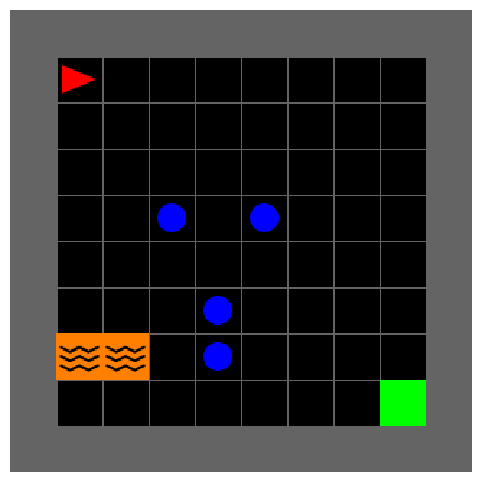

copy 0


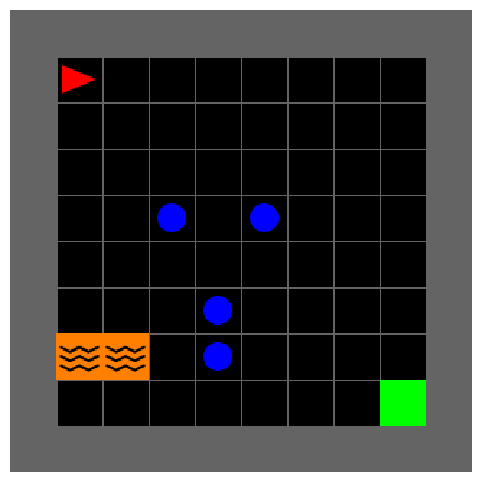

copy 1


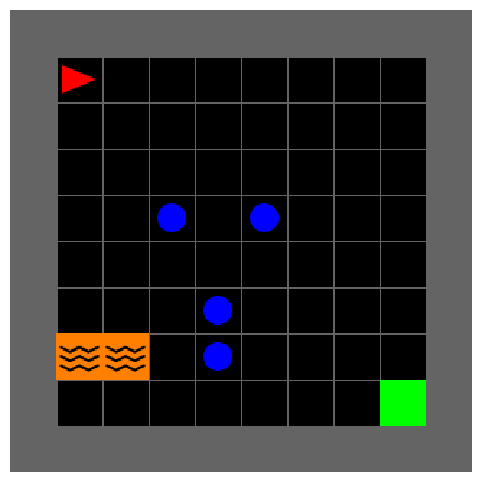

copy 2


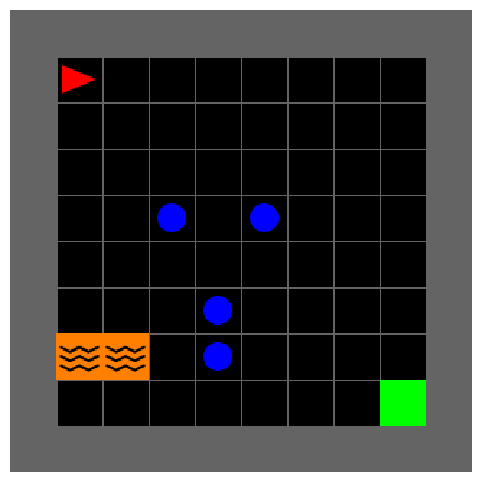

In [ ]:
env = CustomEnv(grid_size=10, render_mode='rgb_array')
env = ObjObsWrapper(env)
env.reset()
print("original environment")
plot_state(env)
for i in range(3):
    copy_env = copy.deepcopy(env)
    print(f"copy {i}")
    plot_state(copy_env)

In [ ]:
def plot_state(env):
    img = env.render()
    plt.imshow(img)
    plt.axis("off")
    plt.show()

In [ ]:
w1_1 = input()
w1_2 = input()
w2_1 = input()
num = int(input())

w1_val = ord(w1_1) - ord('A') + 1
w2_val = ord(w1_2) - ord('A') + 1
w3_val = ord(w2_1) - ord('A') + 1
print(f"w1_val: {w1_val}, w2_val: {w2_val}, w3_val: {w3_val}")
sum = w1_val + w2_val + w3_val
avg = sum/3

if avg == w1_val or avg == w2_val or avg == w3_val:
    print(avg)

elif sum%num == 0:
    print(sum)
    
else:
    print(sum%num)

w1_val: 13, w2_val: 1, w3_val: 14
28


: 

### Manual Control

In [ ]:
from minigrid_custom_env import CustomEnv
# from base_env import SimpleEnv 
from minigrid.manual_control import ManualControl

env = CustomEnv(render_mode="human", difficult_grid=True, agent_pov=True)

# enable manual control for testing
manual_control = ManualControl(env, seed=42)
manual_control.start()

    


error: video system not initialized

In [ ]:
# Load the TensorBoard extension
%load_ext tensorboard

# Start TensorBoard
%tensorboard --logdir logs

## RL Control


### train with DQN

In [ ]:
from rl.agents import DQNAgent  # pip install keras-rl2
from rl.policy import BoltzmannQPolicy  # important to have gym==0.25.2
from rl.memory import SequentialMemory


env = SimpleEnv(render_mode="rgb_array", max_steps=10)
env = FullyObsWrapper(env)
states = env.observation_space.shape[0]
actions = env.action_space.n

print(states)
print(actions)



ImportError: cannot import name '__version__' from 'tensorflow.keras' (c:\Users\matan\miniconda3\envs\my_project\lib\site-packages\keras\api\_v2\keras\__init__.py)

In [ ]:
model = Sequential()
model.add(Flatten(input_shape=(1, states)))
model.add(Dense(128, activation="relu"))
model.add(Dense(128, activation="relu"))
model.add(Dense(actions, activation="linear"))

agent = DQNAgent(
    model=model,
    memory=SequentialMemory(limit=50000, window_length=1),
    policy=BoltzmannQPolicy(),
    nb_actions=actions,
    nb_steps_warmup=10,
    target_model_update=0.01
)
agent.compile(Adam(lr=0.001), metrics=["mae"])


In [ ]:
agent.fit(env, nb_steps=100000, visualize=False, verbose=1)

results = agent.test(env, nb_episodes=10, visualize=True)
print(np.mean(results.history["episode_reward"]))

env.close()

### Train With PPO

In [ ]:
import minigrid
from minigrid.wrappers import ImgObsWrapper
from stable_baselines3 import PPO
from custom_env import *

from custom_env import SimpleEnv 
import os

models_dir = "models/PPO"
log_dir = "logs"
if not os.path.exists(models_dir):
    os.makedirs(models_dir)
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

env = SimpleEnv(render_mode="rgb_array", max_steps=10)
env = FullyObsWrapper(env)

policy_kwargs = dict(
    features_extractor_class=MinigridFeaturesExtractor,
    features_extractor_kwargs=dict(features_dim=128),
)

env = SimpleEnv(render_mode="rgb_array", max_steps=10)
env = ImgObsWrapper(env)

model = PPO("CnnPolicy", env, policy_kwargs=policy_kwargs, verbose=1, tensorboard_log=log_dir)

TIMSTEMPS = 10000
for i in range(1, 15):
    model.learn(total_timesteps=TIMSTEMPS, reset_num_timesteps=False, tb_log_name="PPO")
    model.save(f"{models_dir}/model_{i}")
# model.learn(2e5)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
Logging to logs\PPO_0
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 10       |
|    ep_rew_mean     | 32.5     |
| time/              |          |
|    fps             | 399      |
|    iterations      | 1        |
|    time_elapsed    | 5        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10          |
|    ep_rew_mean          | 39.5        |
| time/                   |             |
|    fps                  | 266         |
|    iterations           | 2           |
|    time_elapsed         | 15          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.016745023 |
|    clip_fraction        | 0.259       |

#### load a model

In [ ]:
model_path = f"{models_dir}/model_13.zip"
load_model = PPO.load(model_path, env=env)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


In [ ]:
import torch

# extractor = MinigridFeaturesExtractor(env.observation_space, features_dim=128)
test_env = SimpleEnv(render_mode="rgb_array", max_steps=10, change_reward=True)
test_env = ImgObsWrapper(test_env)  # Wrap the environment if needed

env = SimpleEnv(render_mode="rgb_array", max_steps=10)
env = ObjObsWrapper(env)
# Reset the environment to get the initial observation
obs = env.reset()
print(env.observation_space)
extractor = MinigridFeaturesExtractor(env.observation_space['image'], features_dim=128)

done = False
while not done:
# Use the model to predict the next action
    # obs = torch.from_numpy(obs[0]).float().unsqueeze(0)
    # obs = extractor.forward(obs)
    obs = extractor.forward(obs)
    print(obs.shape)

    action, _states = model.predict(obs[0], deterministic=True)
    
    # You can then take the action in the environment to move to the next state
    obs, reward, done, truncated, info = env.step(action)
    

    # If you want to visualize the action taken, you can render the environment
    env.render()


Dict('image': Box(0, 255, (7, 7, 3), uint8))


RuntimeError: Calculated padded input size per channel: (5 x 1). Kernel size: (2 x 2). Kernel size can't be greater than actual input size

### Random Agent

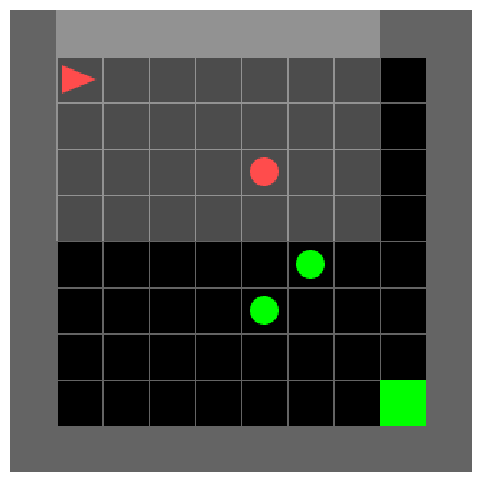

Action: 3,  Reward: 2, Done: False, Truncated: True, Info: {}


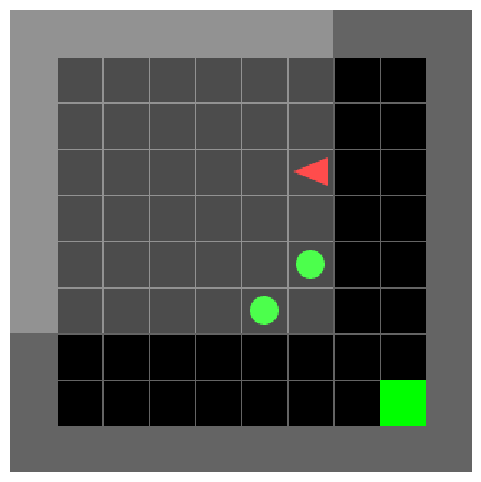

Action: 3,  Reward: 1.5, Done: False, Truncated: True, Info: {}


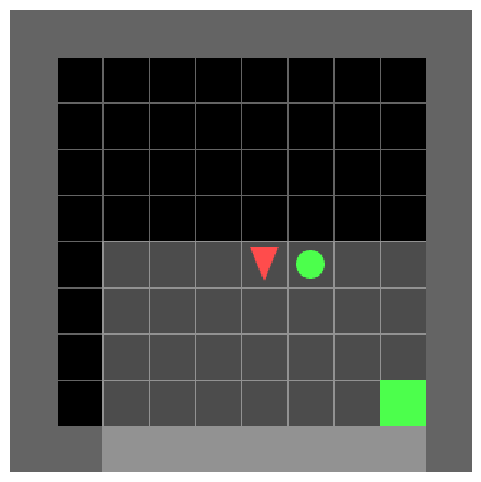

Action: 2,  Reward: -110.69, Done: True, Truncated: True, Info: {}


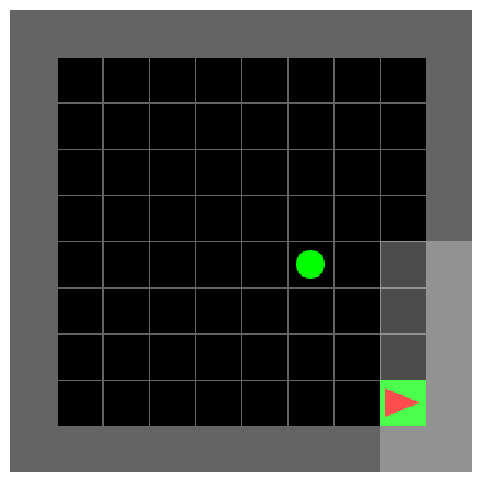

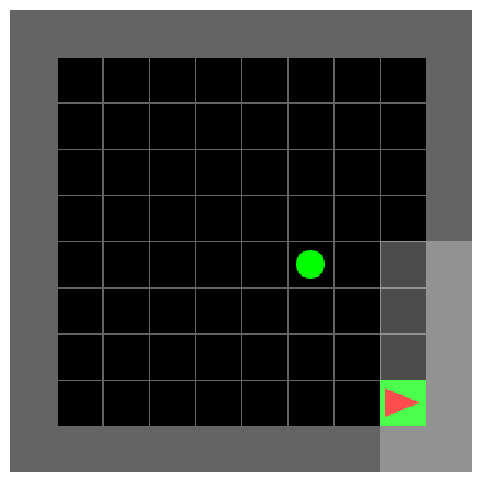

episode 0: score: -107.19


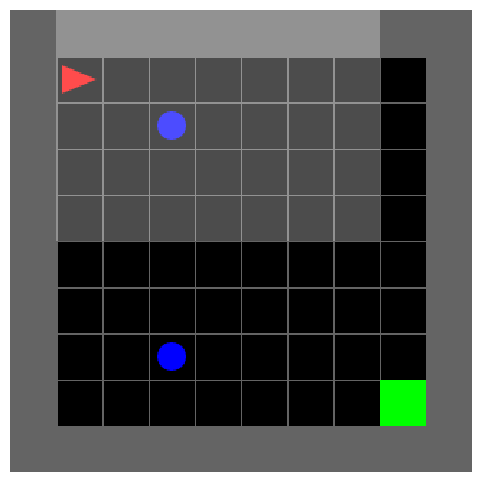

Action: 3,  Reward: 1, Done: False, Truncated: True, Info: {}


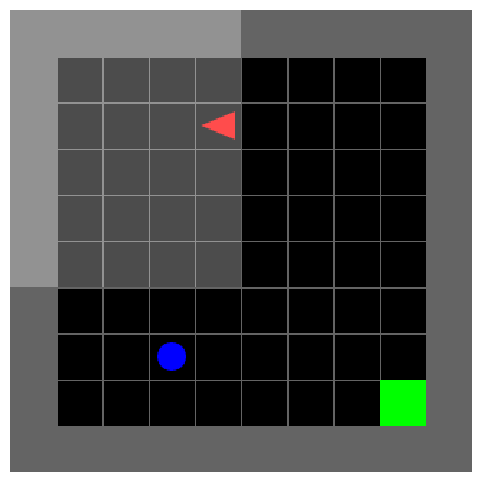

Action: 2,  Reward: -31.580000000000005, Done: True, Truncated: True, Info: {}


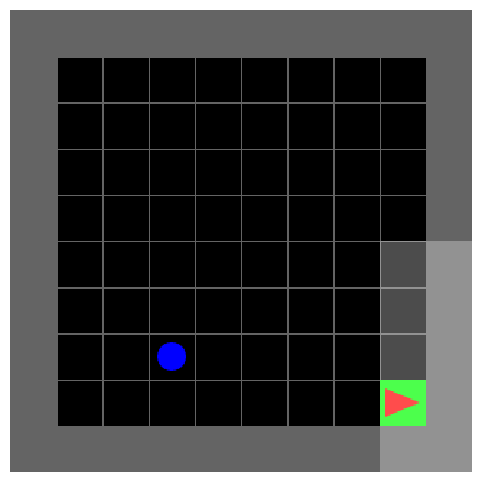

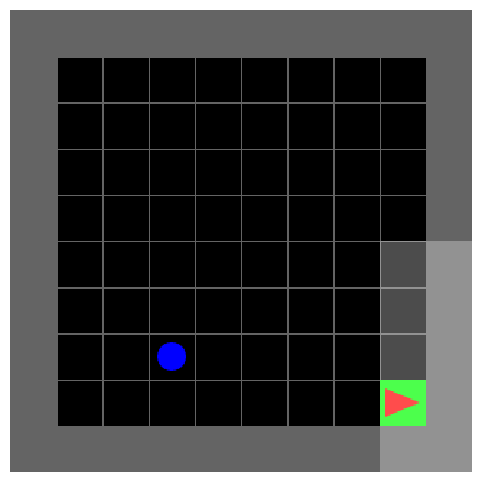

episode 1: score: -30.580000000000005


In [ ]:
def plot_state(env):
    img = env.render()
    plt.imshow(img)
    plt.axis("off")
    plt.show()

env = SimpleEnv(render_mode="rgb_array", max_steps=10)
num_episodes = 2
for i in range(num_episodes):
# Reset the environment to get the initial state
    state, info = env.reset()
    # plot_state(env)
    score = 0
    # Run the simulation
    done = False
    plot_state(env)
    while not done:
        # Sample a random action from the action space
        action = env.action_space.sample()

        # Take the action in the environment
        state, reward, done, truncated, info = env.step(action)
        score += reward
        if reward != 0:
            print(f"Action: {action},  Reward: {reward}, Done: {done}, Truncated: {truncated}, Info: {info}")
            plot_state(env)
            
    plot_state(env)
    print(f"episode {i}: score: {score}")

env.close()


In [ ]:
from app_db import *
from datetime import datetime

with app.app_context():
    db.create_all()
    players = Player.query.all()

    print(players)

[Player(1, 1)]
